In [98]:
import torch
import numpy as np
import pandas
import music21
from music21 import *
import os
import IPython
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import copy

In [99]:
import os
import music21

path = 'dataset/tschai/'
all_midis = []

for i in os.listdir(path):
    if i.endswith('.mid'):
        tr = os.path.join(path, i)
        try:
            midi = music21.converter.parse(tr)
            all_midis.append(midi)
        except Exception as e:
            print(f"Error loading {tr}: {e}")

print(f"Loaded {len(all_midis)} MIDI files.")


Loaded 12 MIDI files.


##### Iteriamo sulla lista per memorizzare note o accordi. Se presenti, suddividiamo il file midi in strumenti. Con recurse prendiamo tutti gli elementi musicali.

In [100]:
def extract_notes(file):
    notes = []
    pick = None
    for f in file:
        song = instrument.partitionByInstrument(f)
        for part in song.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes
notes = extract_notes(all_midis)
print(len(notes))

12451


In [101]:
print(f"First 50 ntoes: {notes[:50]}")

First 50 ntoes: ['F4', 'G4', '10.2.5', '10.2.5', '10.2.5', 'A4', '10.2.5', '10.2.5', 'B-4', 'D5', '3.5.9', '3.5.9', 'C5', '3.5.9', '3.5.9', 'F4', 'B4', '2.5.8', '2.5.8', 'C5', '2.5.8', '2.5.8', 'D5', 'F5', '0.3.7', '0.3.7', 'E-5', '0.3.7', '0.3.7', 'E-5', 'E5', '1.4.7.9', '1.4.7.9', 'B-5', '1.4.7.9', '1.4.7.9', 'A5', 'A4', '2.5.9', '2.5.9', 'B-5', '2.5.9', '2.5.9', 'A5', 'A4', '1.4.7.9', '1.4.7.9', 'B-5', '1.4.7.9', '1.4.7.9']


##### La funzione converte una lista di note e accordi in oggetti musicali comprensibili dalla libreria music21. Itera su ogni elemento nella lista notes. Se l'elemento rappresenta un accordo (cioè contiene un punto o è un numero), lo converte in un oggetto Chord. Altrimenti, lo converte in un oggetto Note. Ogni oggetto Note o Chord viene assegnato un "offset" che determina quando deve essere suonato, incrementando l'offset di 1 per ogni nota o accordo successivo. Tutti gli oggetti musicali vengono aggiunti alla lista melody, che viene poi trasformata in un oggetto stream.Stream, contenente la sequenza musicale finale.

In [102]:
def show(music):
    music.write('midi', 'img/output.mid')

def chords_n_notes(notes):
    melody = []
    offset = 0
    for n in notes:
        if ('.' in n) or n.isdigit():
            chord_notes = n.split('.')
            note_objs = [note.Note(int(j)) for j in chord_notes]
            chord_snip = chord.Chord(note_objs)
            chord_snip.offset = offset
            melody.append(chord_snip)
        else:
            note_snip = note.Note(n)
            note_snip.offset = offset
            melody.append(note_snip)
        offset += 1

    melody_midi = stream.Stream(melody)   
    return melody_midi

# melody_midi = chords_n_notes(notes)
# show(melody_midi)


##### Questo script utilizza la libreria collections.Counter per contare la frequenza di ogni nota (o accordo) nella lista notes

In [103]:
count_num = Counter(notes)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 243


In [104]:
keys = list(count_num.keys())
values = list(count_num.values())

def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(values))
print("Most frequent note in Corpus appeared:", max(values), "times")
print("Least frequent note in Corpus appeared:", min(values), "time")

Average recurrenc for a note in Corpus: 51.23868312757202
Most frequent note in Corpus appeared: 328 times
Least frequent note in Corpus appeared: 1 time


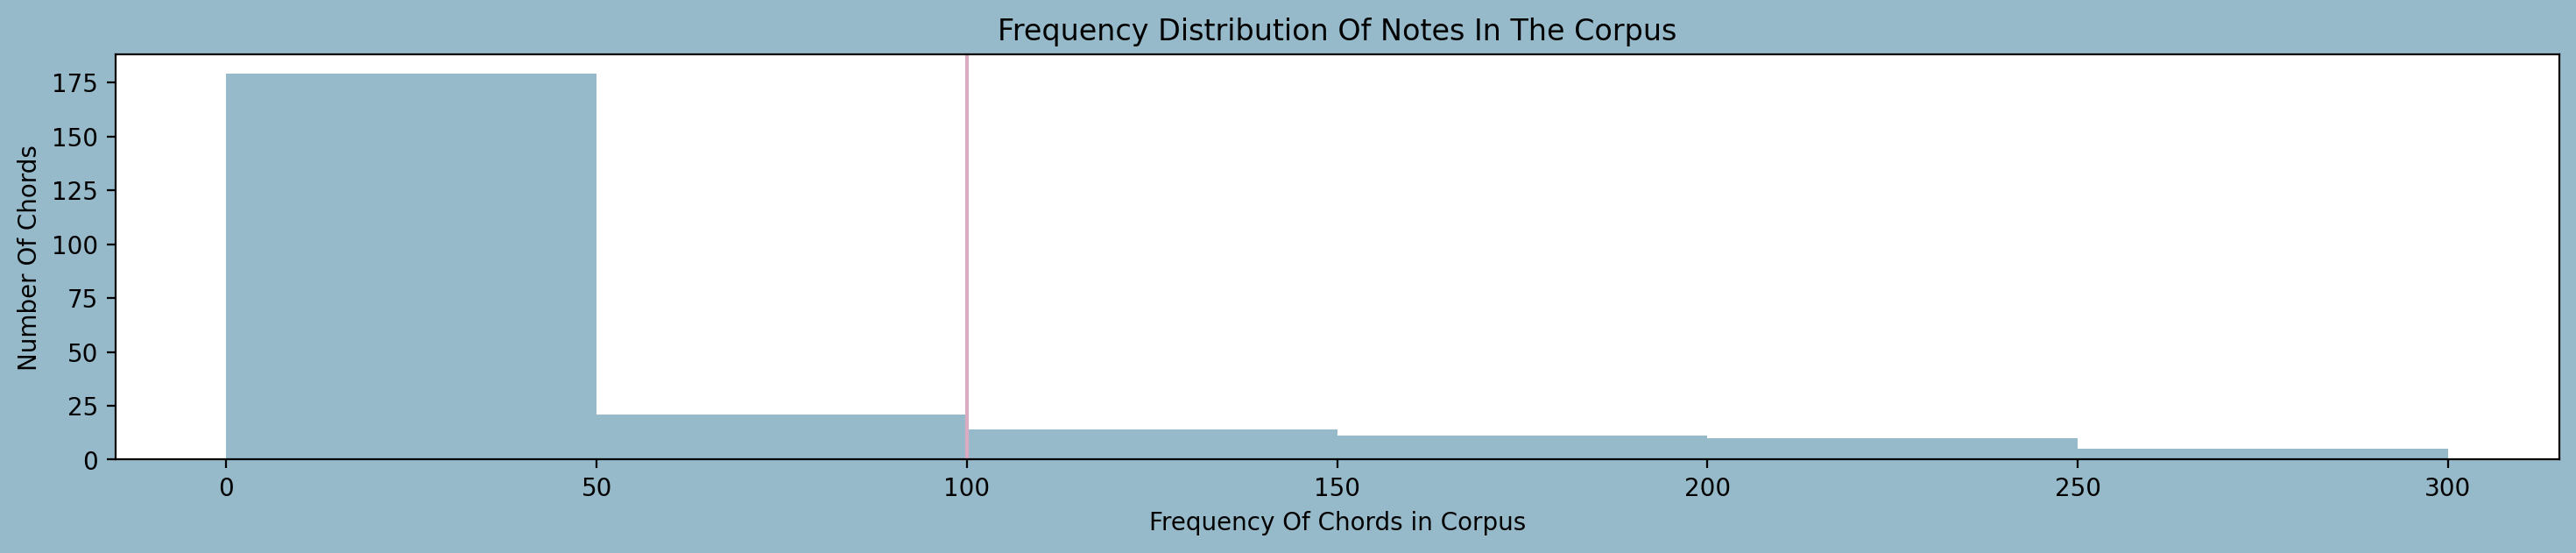

In [105]:
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(values)), 50) 
plt.hist(values, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [106]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 200


In [107]:
#Eleminating the rare notes
for element in notes:
    if element in rare_note:
        notes.remove(element)

print("Length of Corpus after elemination the rare notes:", len(notes))

Length of Corpus after elemination the rare notes: 9364


##### Questo blocco di codice si occupa di creare una mappatura tra le note (o gli accordi) uniche e gli indici numerici, utili per l'elaborazione dei dati in un modello LSTM (Long Short-Term Memory). Crea una lista ordinata in cui non ci sono duplicati, calcola la lunghezza della lista originale e di quella nuova. Calcola la lunghezza della lista symb (la nuova), ovvero il numero di note (o accordi) uniche nel corpus. Questo rappresenta la dimensione del vocabolario musicale, cioè il numero di simboli distinti che il tuo modello dovrà "imparare" a gestire. Crea un dizionario che mappa ogni simbolo (nota o accordo) alla sua posizione nell'elenco ordinato symb. La chiave è il simbolo, e il valore è l'indice corrispondente. Crea un dizionario inverso che mappa ogni indice numerico alla sua nota/accordo corrispondente. In pratica, questa è la mappa inversa della precedente. Il mapping inverso (cioè reverse_mapping) è utile per convertire gli indici numerici generati dal modello LSTM di nuovo in note o accordi comprensibili.

In [108]:
symb = sorted(list(set(notes)))

L_corpus = len(notes)
L_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 9364
Number of unique characters: 190


##### Questo blocco di codice prepara i dati per l'allenamento di un modello di generazione musicale, come un LSTM. L'idea principale è suddividere la sequenza di note in sottosequenze (o "sequenze di input") e associare ciascuna sottosequenza al valore che il modello dovrà prevedere, cioè la nota successiva. Definisce la lunghezza delle sequenze di input che il modello userà per fare delle previsioni. Ogni sequenza di input avrà 40 note (o simboli). features conterrà le sequenze di input (di lunghezza 40).targets conterrà la "nota target", cioè la nota che segue la sequenza di input, che il modello dovrà imparare a predire.

In [109]:
length = 20
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = notes[i:i + length]
    target = notes[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 9344


In [110]:
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
y = torch.nn.functional.one_hot(torch.tensor(targets))

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [112]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train) 
y_train_tensor = torch.argmax(y_train_tensor, dim=1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val) 
y_val_tensor = torch.argmax(y_val_tensor, dim=1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test) 
y_test_tensor = torch.argmax(y_test_tensor, dim=1)

/tmp/ipykernel_925/1657894086.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train)
/tmp/ipykernel_925/1657894086.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val)
/tmp/ipykernel_925/1657894086.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test)


### Da qui in poi costruiamo il modello

In [113]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1=512, hidden_size_2=256, dropout_rate=0.1, output_size=None):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size_1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.lstm2 = nn.LSTM(hidden_size_1, hidden_size_2, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size_2, hidden_size_2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size_2, output_size)
        
    def forward(self, x):
        x, (hn, cn) = self.lstm1(x)
        x = self.dropout1(x)
        
        x, (hn, cn) = self.lstm2(x)
        
        #  Prendiamo solo l'output dell'ultimo passo temporale della sequenza, 
        # che rappresenta la "decisione finale" del modello in base a tutte le informazioni
        #  passate nei passi precedenti
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.dropout2(x)
        
        x = self.fc2(x)
        
        return x


In [114]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size_1=512, hidden_size_2=256, hidden_size_3=128, 
                 dropout_rate=0.2, output_size=None):
        super(GRUModel, self).__init__()
        
        # Primo strato GRU
        self.gru1 = nn.GRU(input_size, hidden_size_1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Secondo strato GRU
        self.gru2 = nn.GRU(hidden_size_1, hidden_size_2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Terzo strato GRU (aggiunto per maggiore capacità)
        self.gru3 = nn.GRU(hidden_size_2, hidden_size_3, batch_first=True)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_size_3)
        
        # Strato fully connected
        self.fc1 = nn.Linear(hidden_size_3, hidden_size_3)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc2 = nn.Linear(hidden_size_3, output_size)    
    
    
    def forward(self, x):
        # Primo strato GRU
        x, hn = self.gru1(x)
        x = self.dropout1(x)
        
        # Secondo strato GRU
        x, hn = self.gru2(x)
        x = self.dropout2(x)
        
        # Terzo strato GRU
        x, hn = self.gru3(x)
        x = self.dropout3(x)
        
        # Batch normalization sull'output dell'ultimo passo temporale
        x = x[:, -1, :]  # Prendi solo l'ultimo passo temporale
        x = self.bn1(x)
        
        # Strato fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200


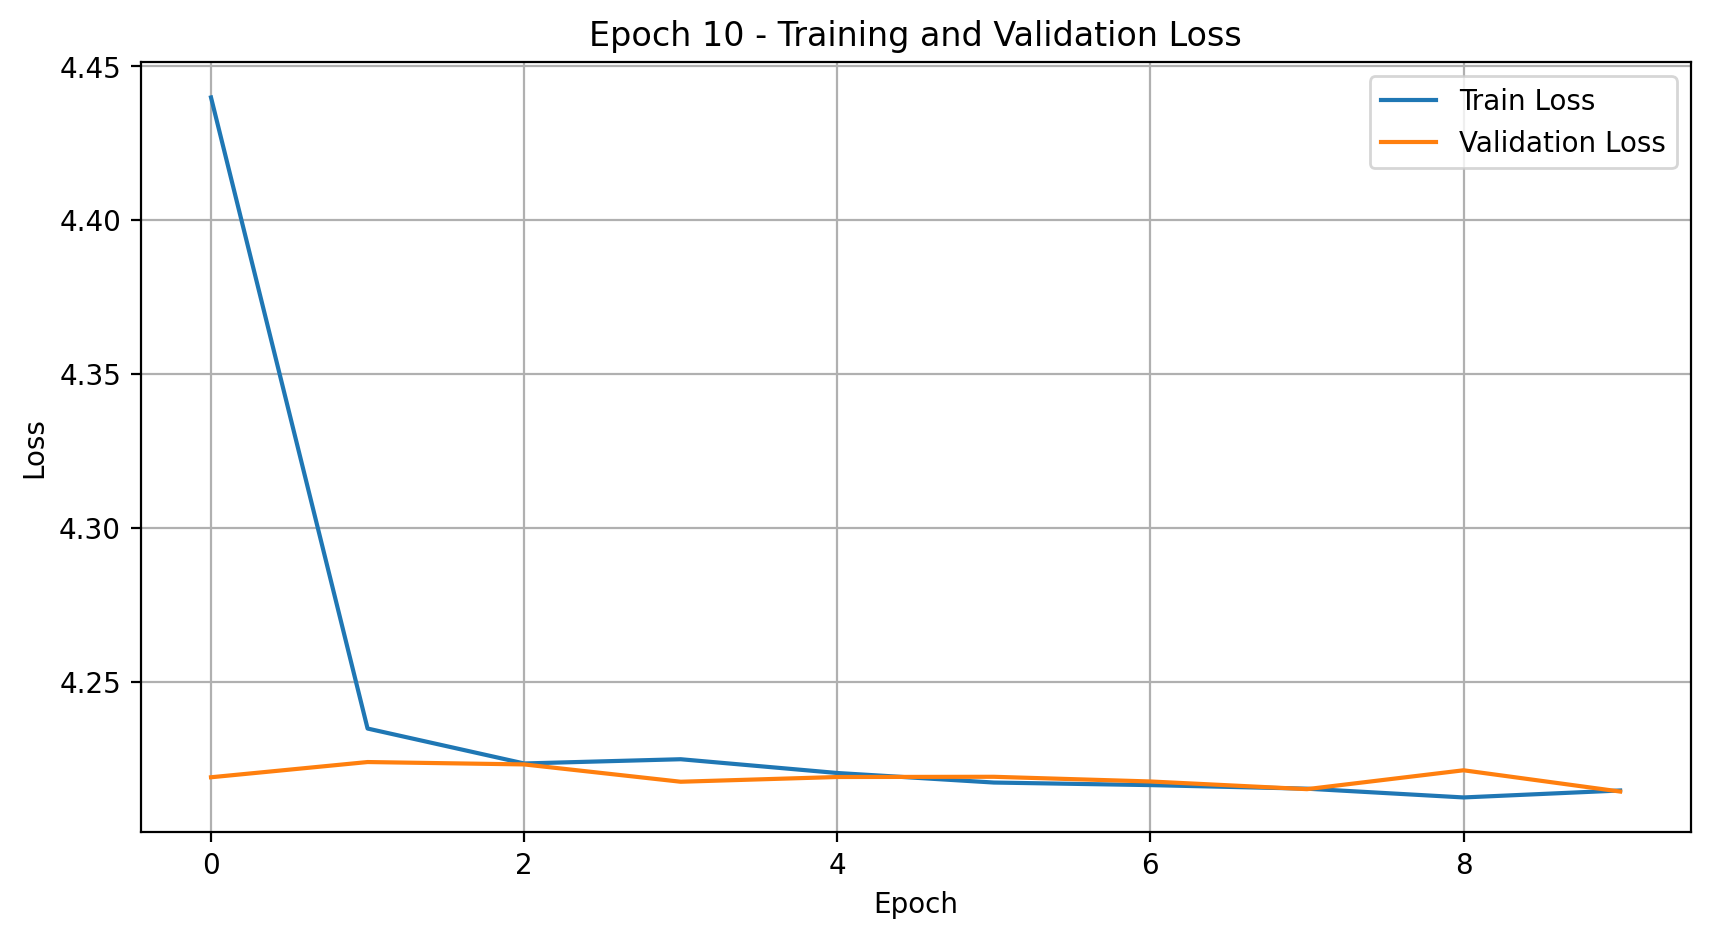

Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200


<Figure size 640x480 with 0 Axes>

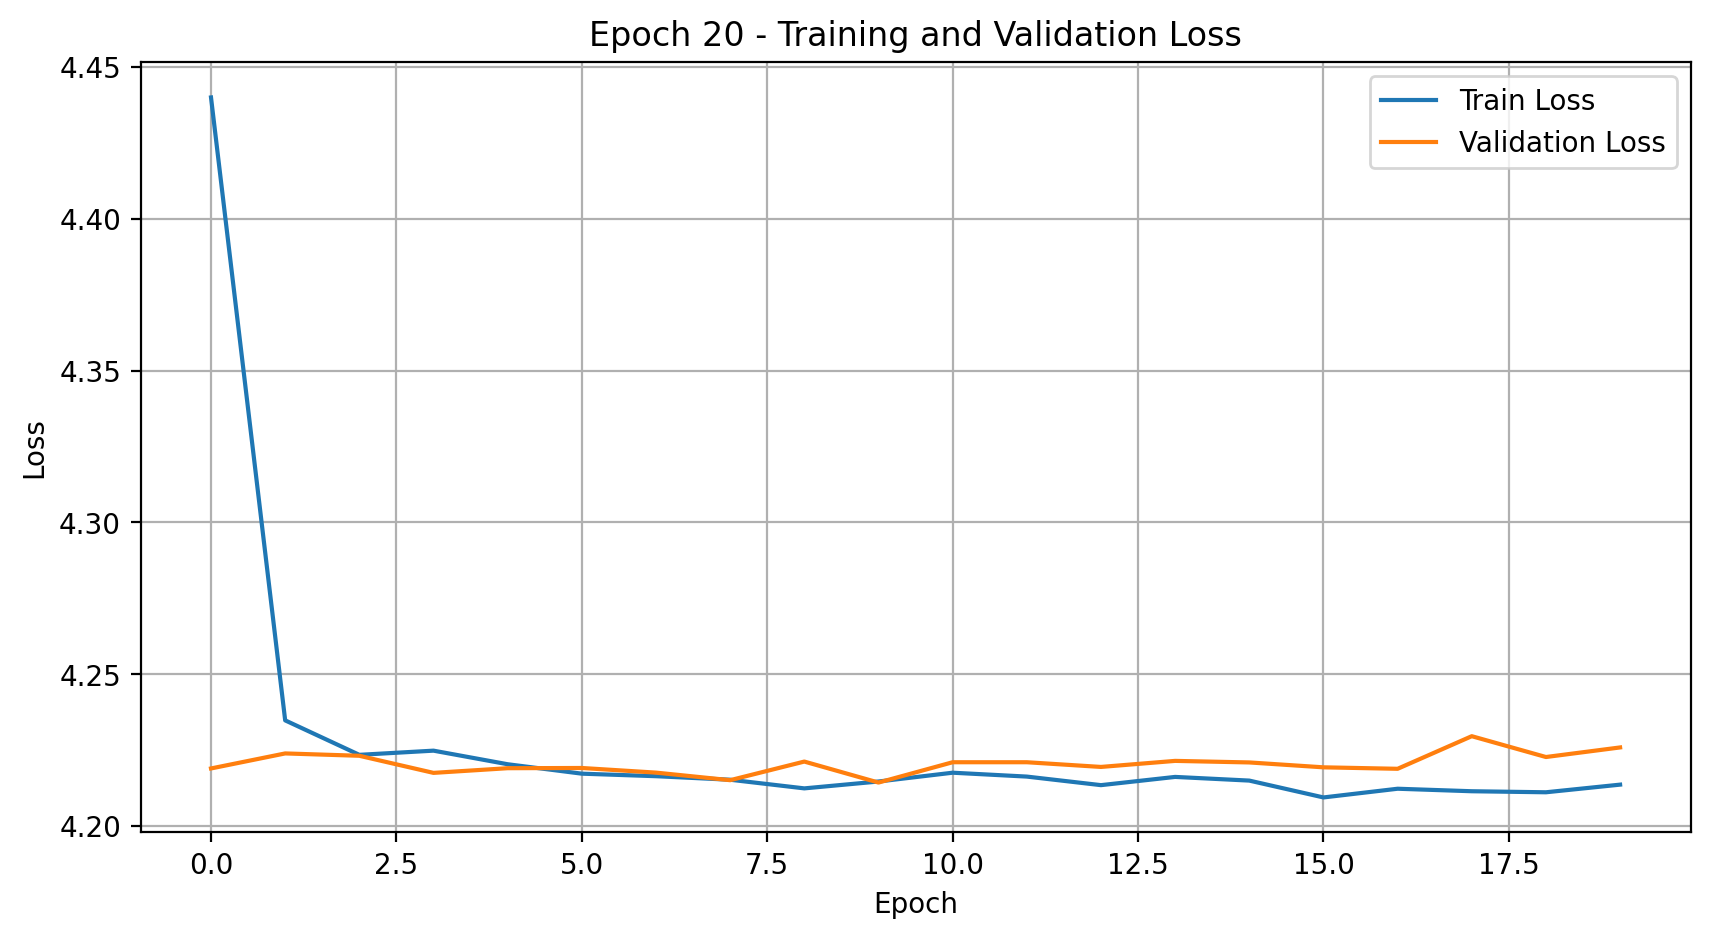

Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200


<Figure size 640x480 with 0 Axes>

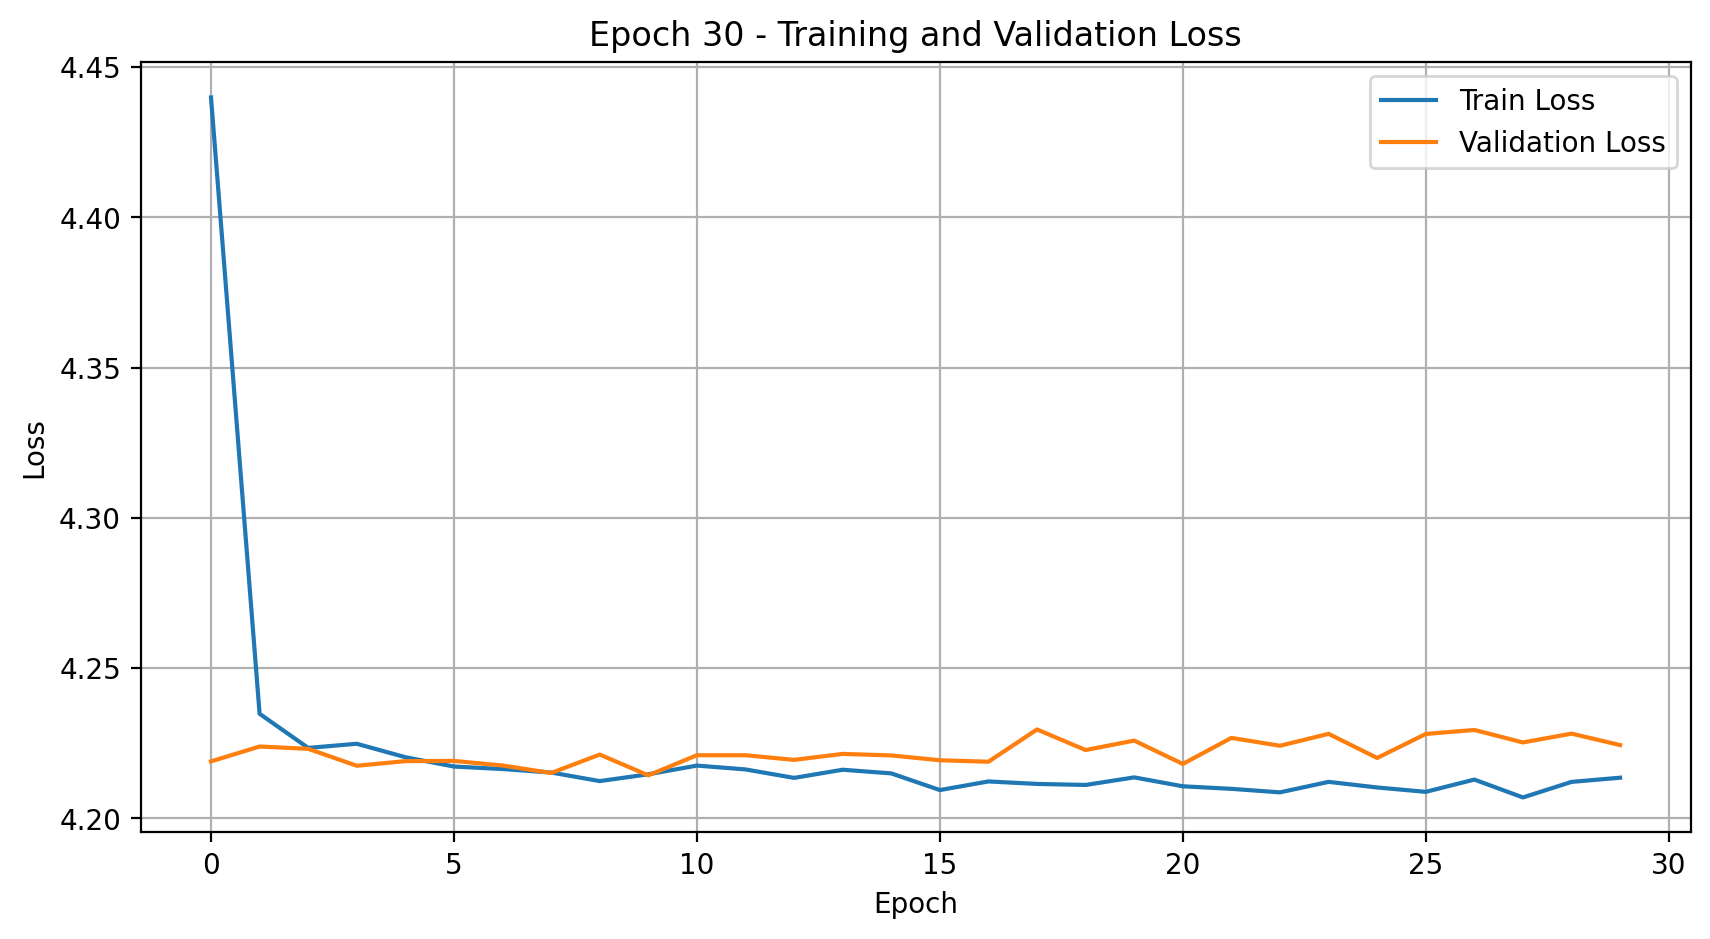

Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200


<Figure size 640x480 with 0 Axes>

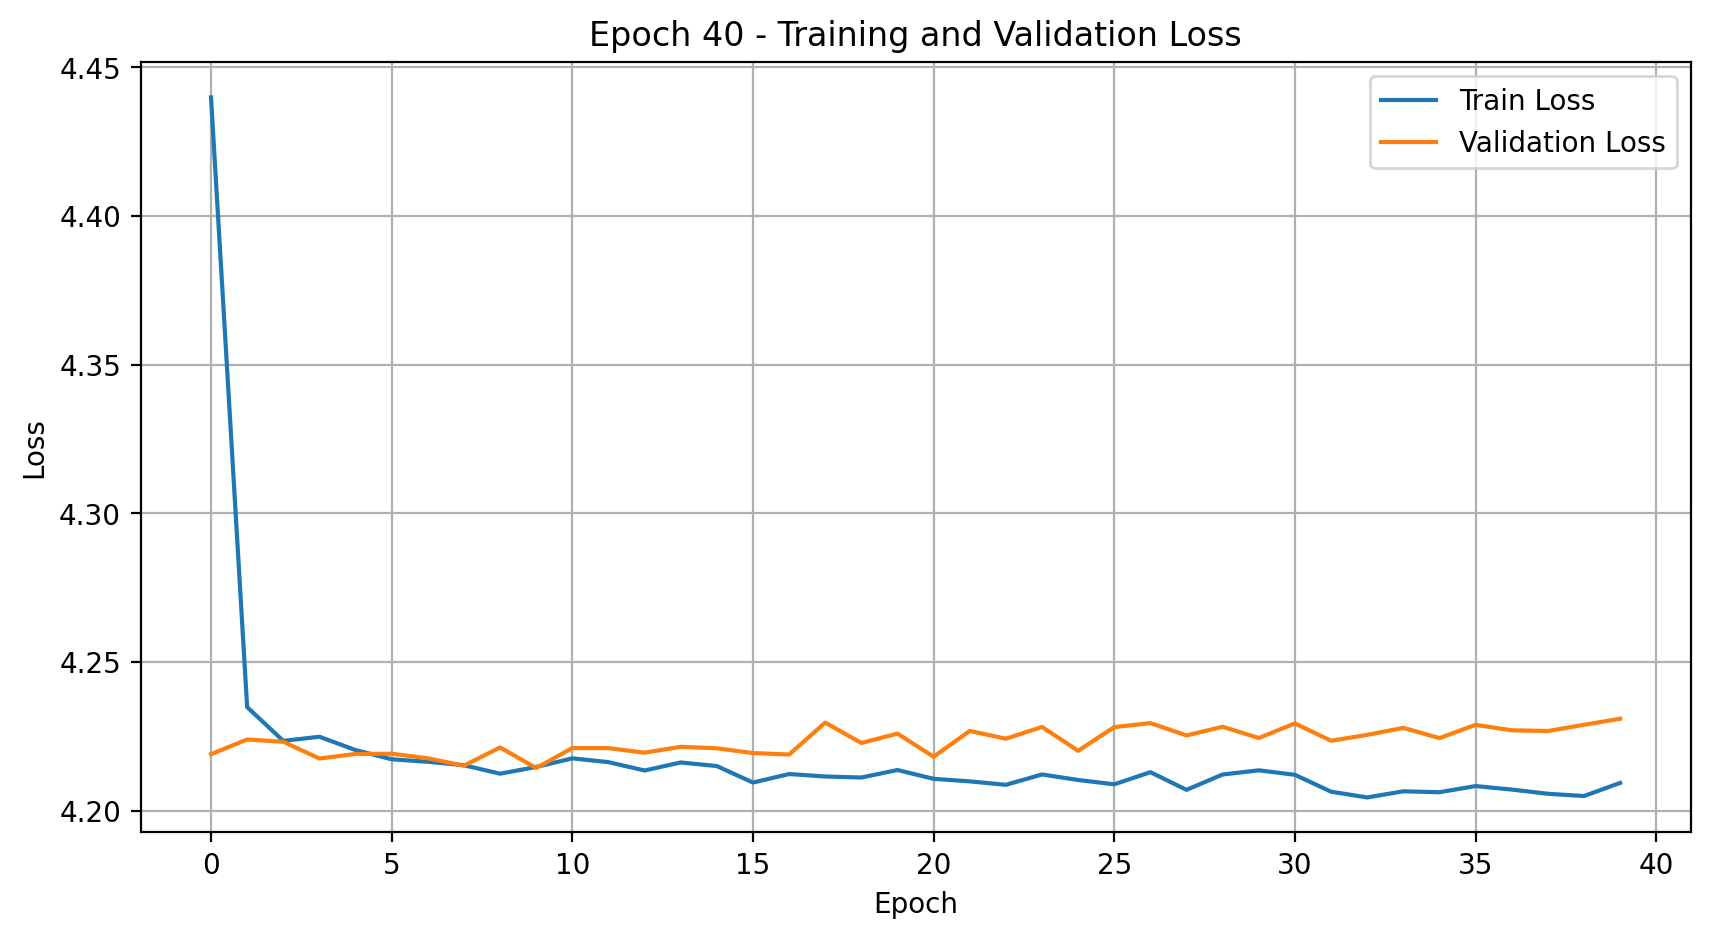

Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200


<Figure size 640x480 with 0 Axes>

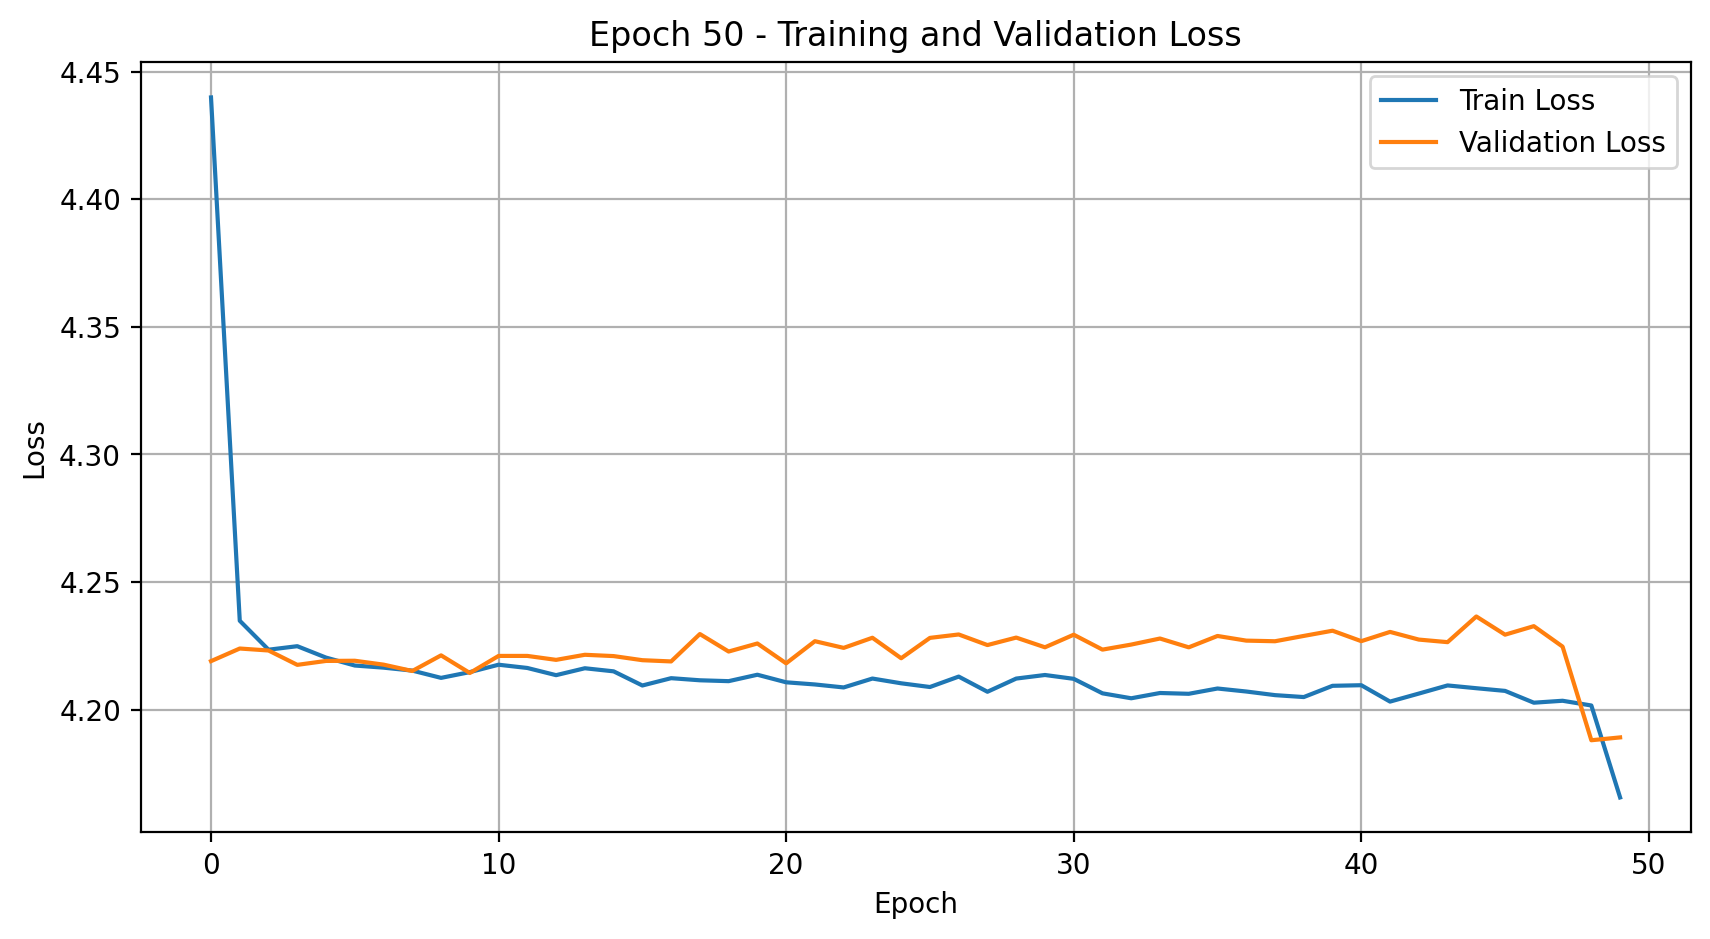

Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200


<Figure size 640x480 with 0 Axes>

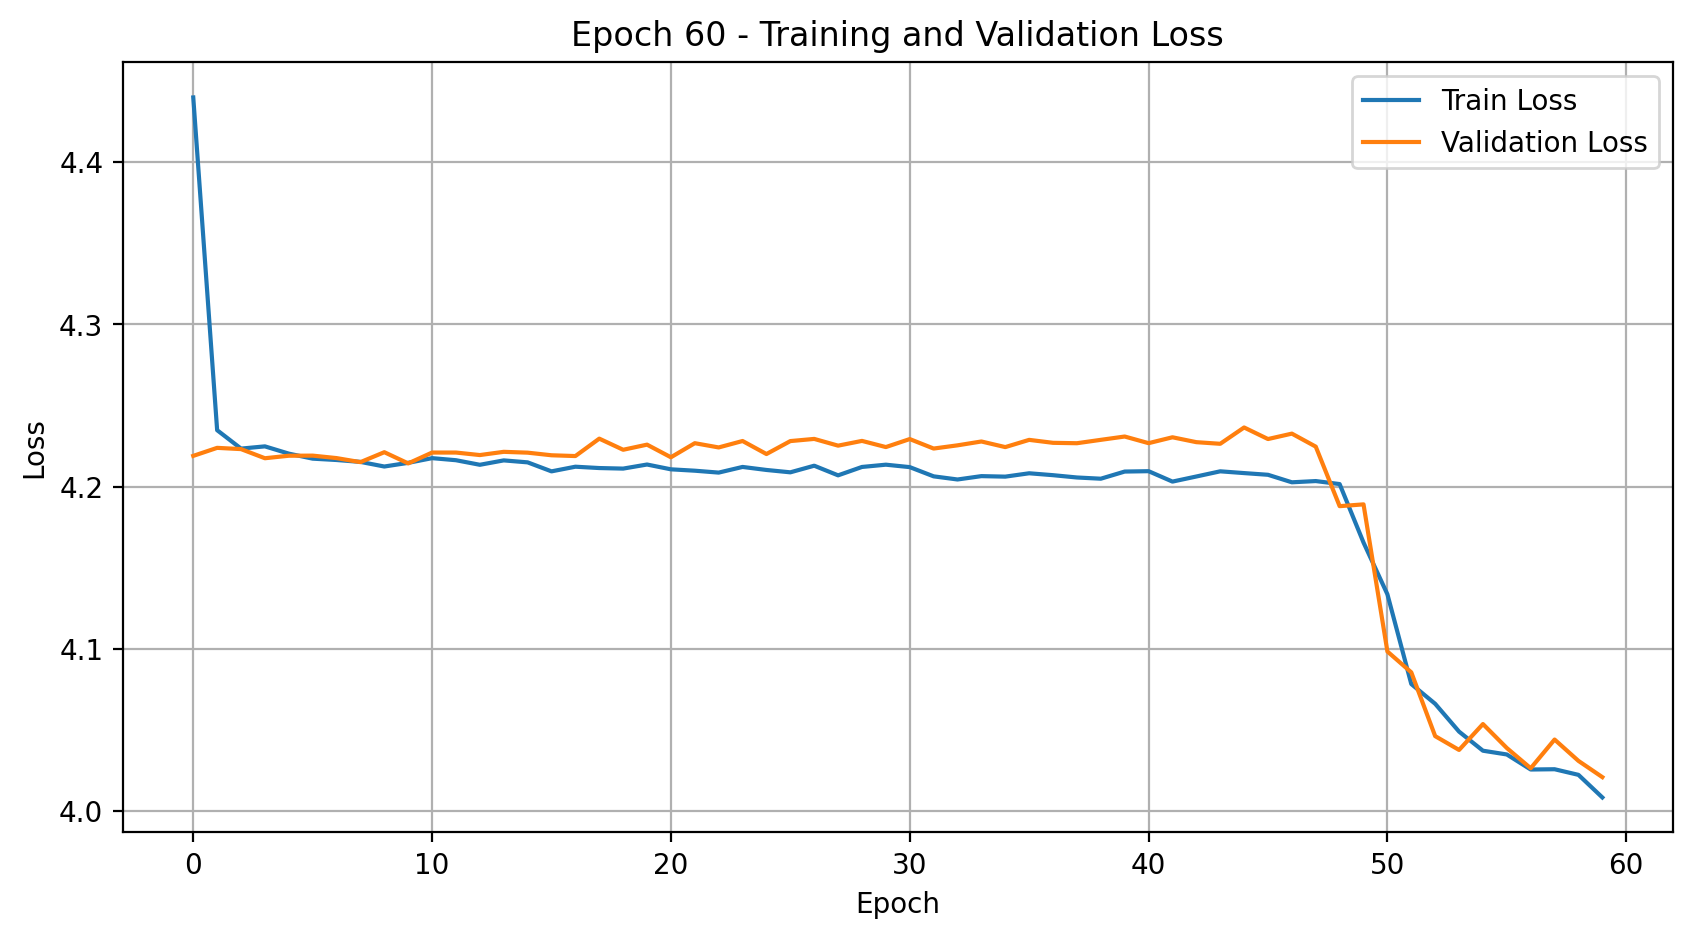

Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200


<Figure size 640x480 with 0 Axes>

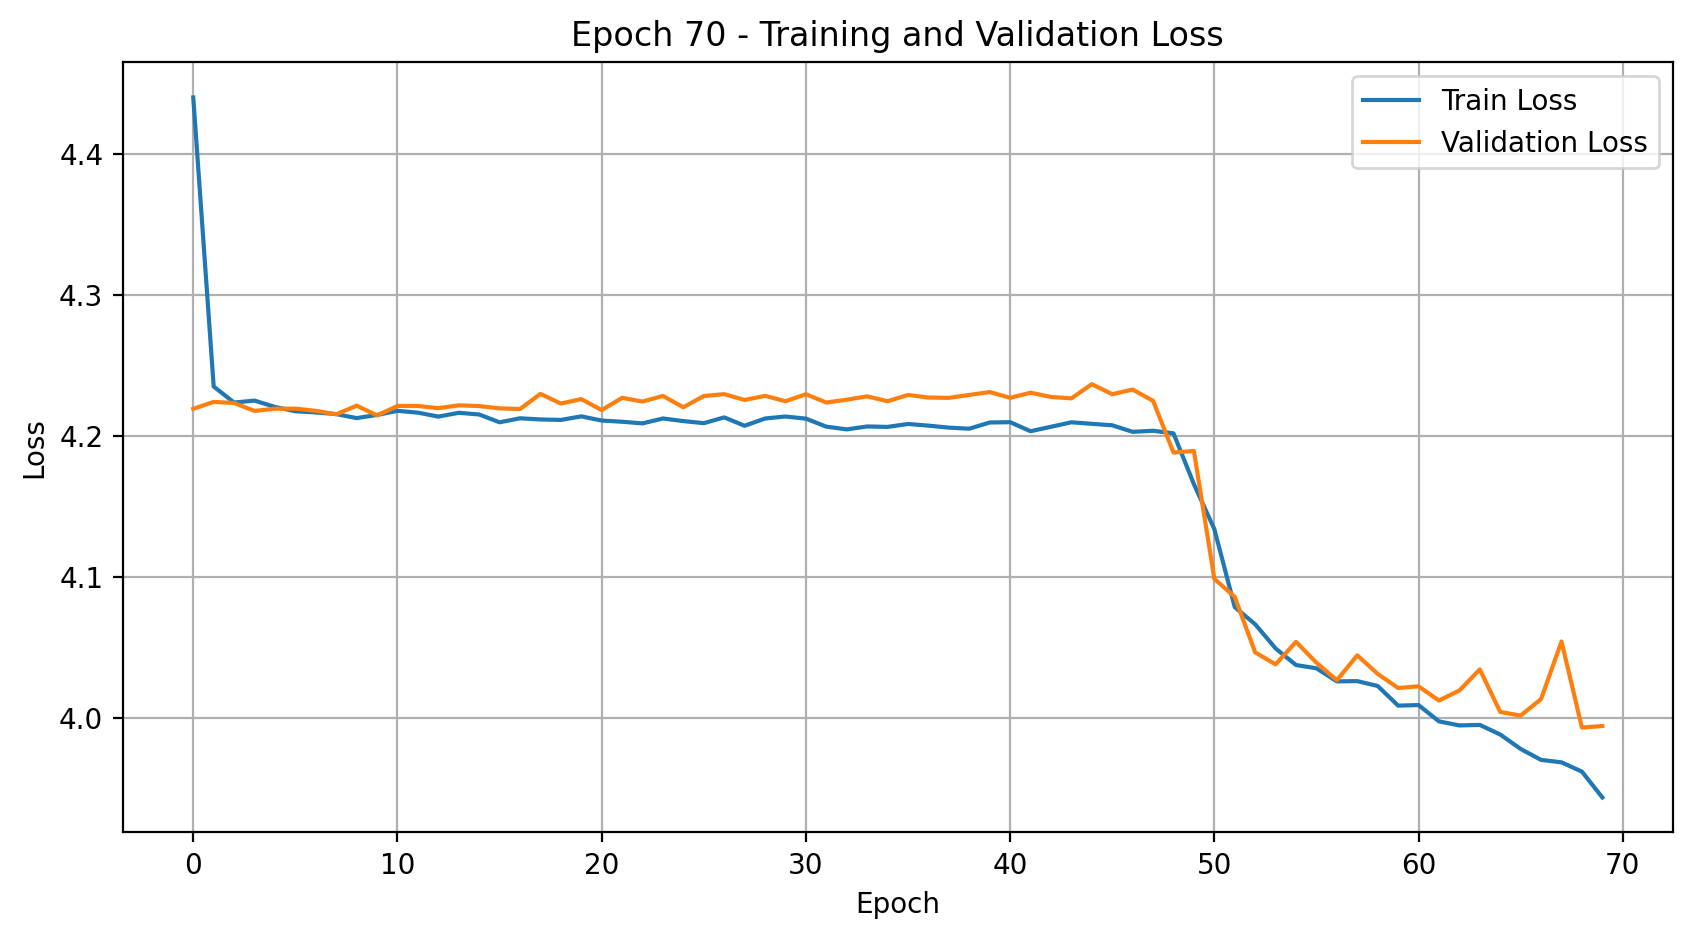

Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78/200
Epoch 79/200
Epoch 80/200


<Figure size 640x480 with 0 Axes>

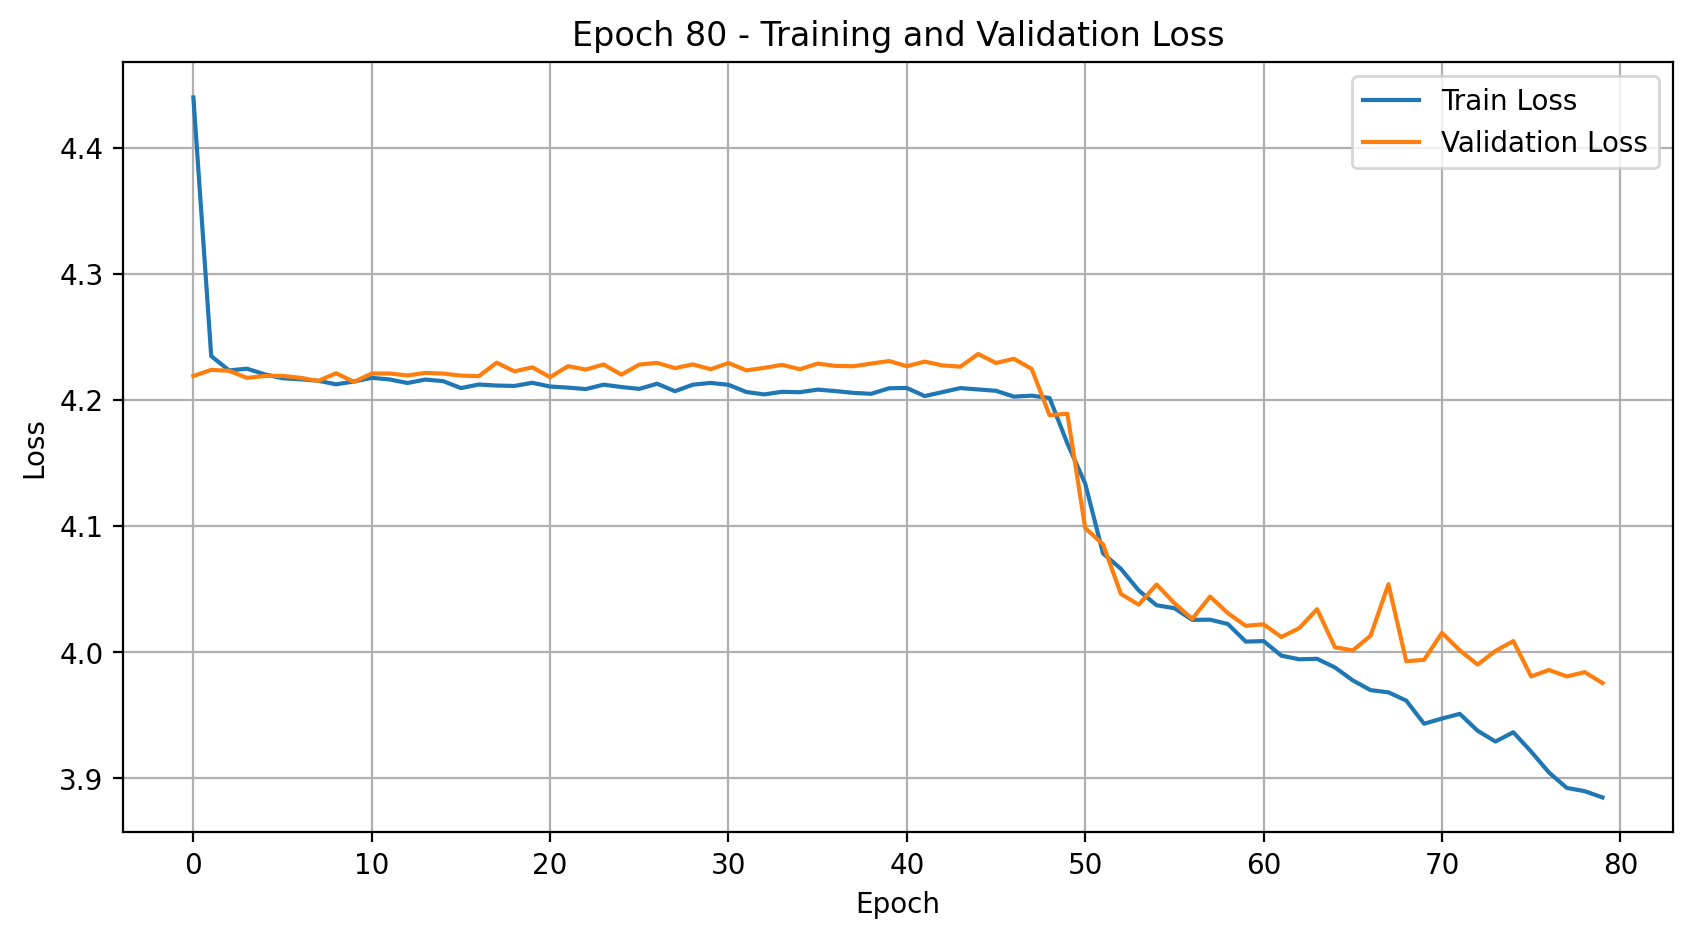

Epoch 81/200
Epoch 82/200
Epoch 83/200
Epoch 84/200
Epoch 85/200
Epoch 86/200
Epoch 87/200
Epoch 88/200
Epoch 89/200
Epoch 90/200


<Figure size 640x480 with 0 Axes>

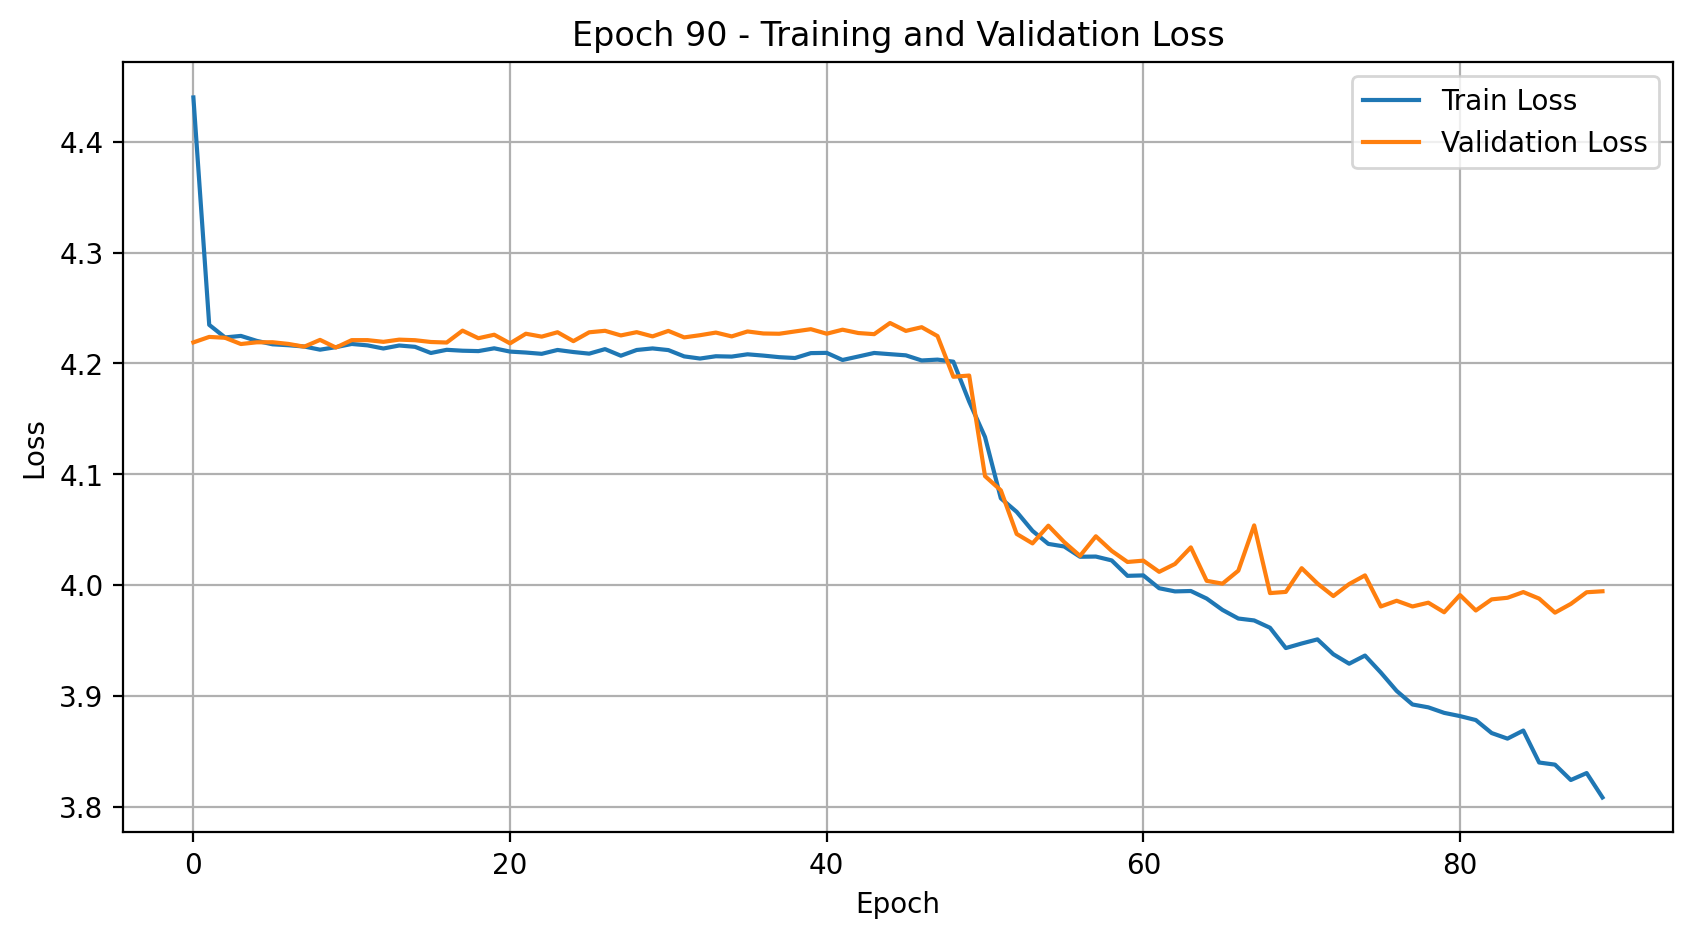

Epoch 91/200
Epoch 92/200
Epoch 93/200
Epoch 94/200
Epoch 95/200
Epoch 96/200
Epoch 97/200
Epoch 98/200
Epoch 99/200
Epoch 100/200


<Figure size 640x480 with 0 Axes>

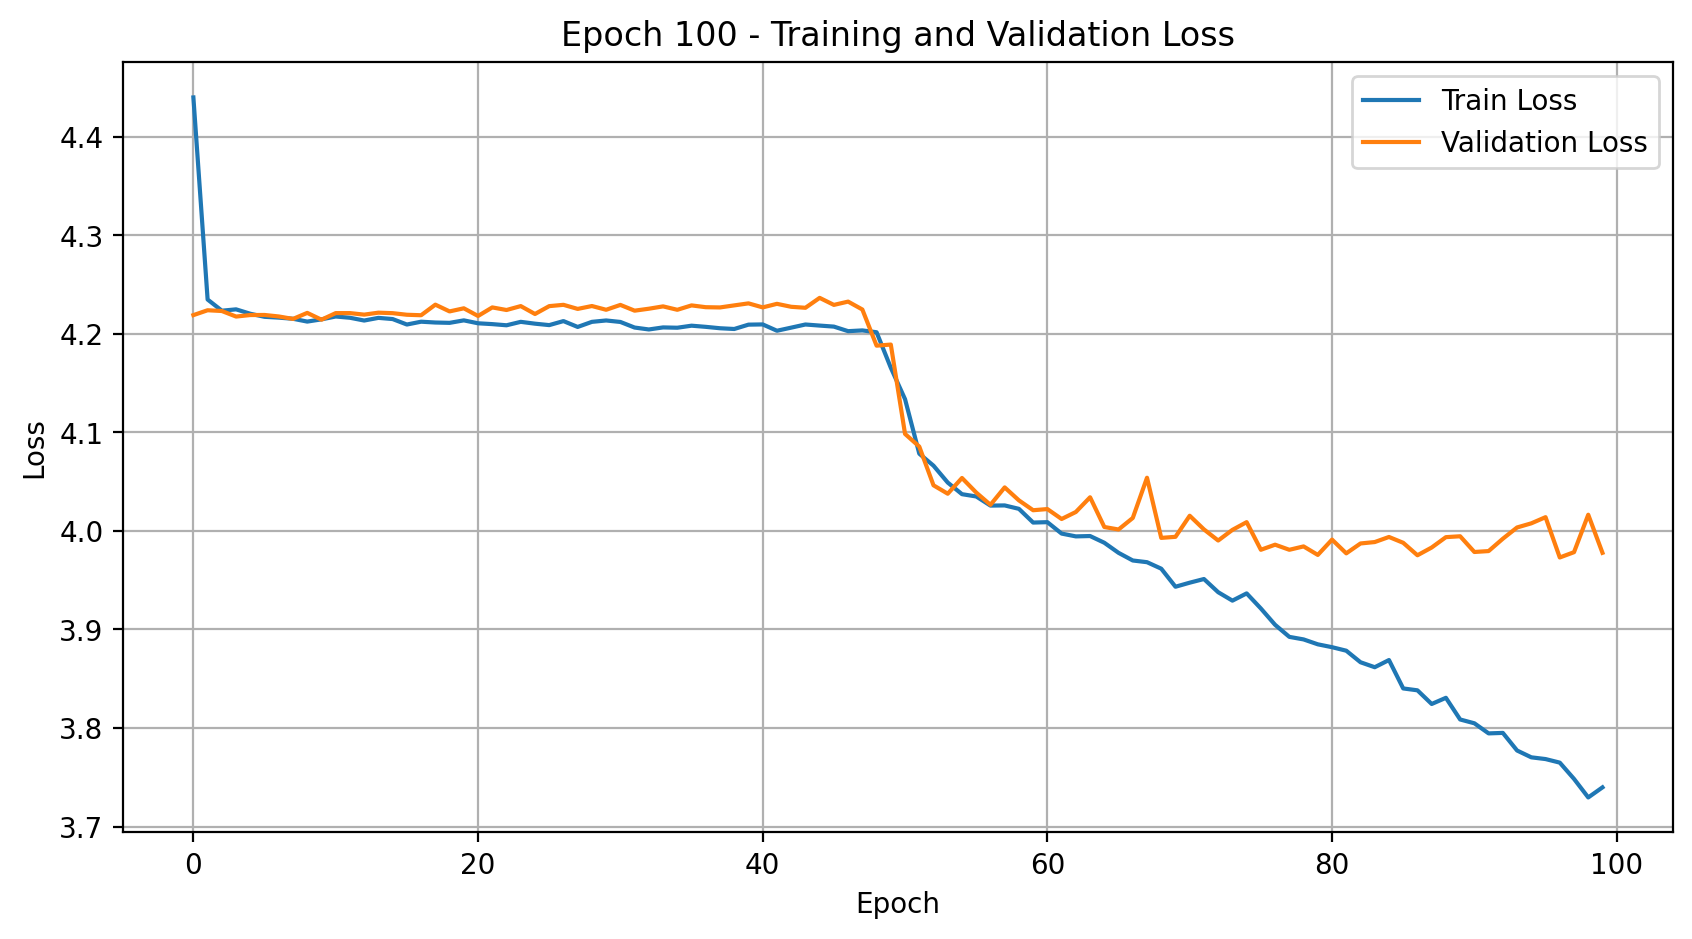

Epoch 101/200
Epoch 102/200
Epoch 103/200
Epoch 104/200
Epoch 105/200
Epoch 106/200
Epoch 107/200
Epoch 108/200
Epoch 109/200
Epoch 110/200


<Figure size 640x480 with 0 Axes>

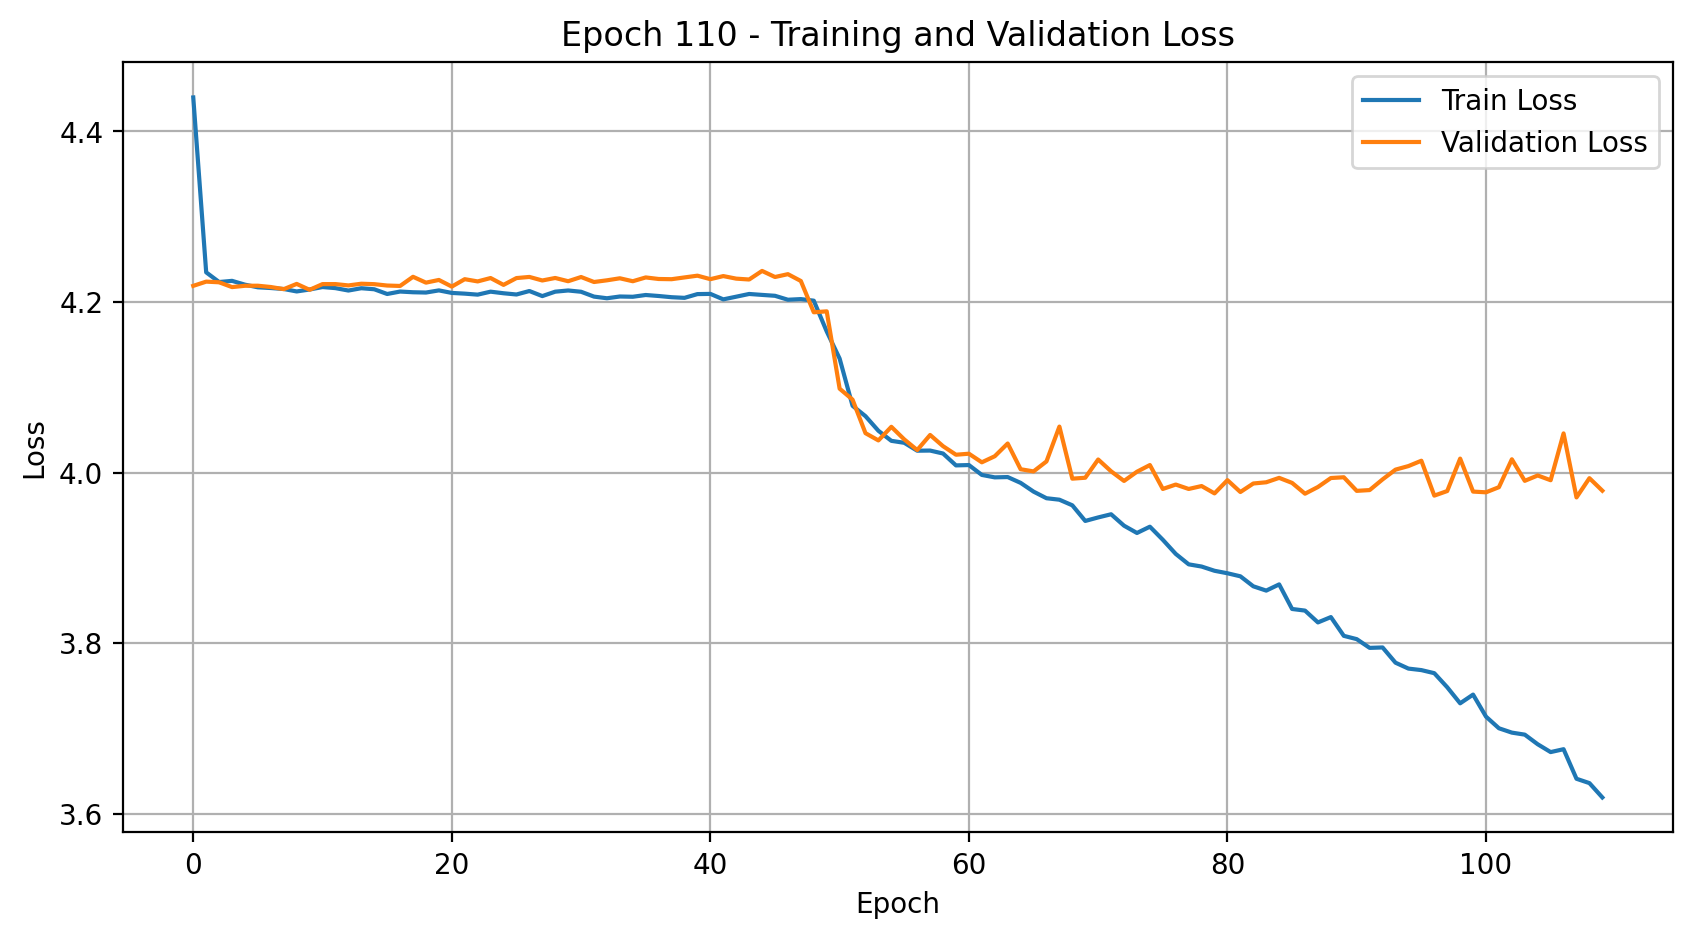

Epoch 111/200
Epoch 112/200
Epoch 113/200
Epoch 114/200
Epoch 115/200
Epoch 116/200
Epoch 117/200
Epoch 118/200
Epoch 119/200
Epoch 120/200


<Figure size 640x480 with 0 Axes>

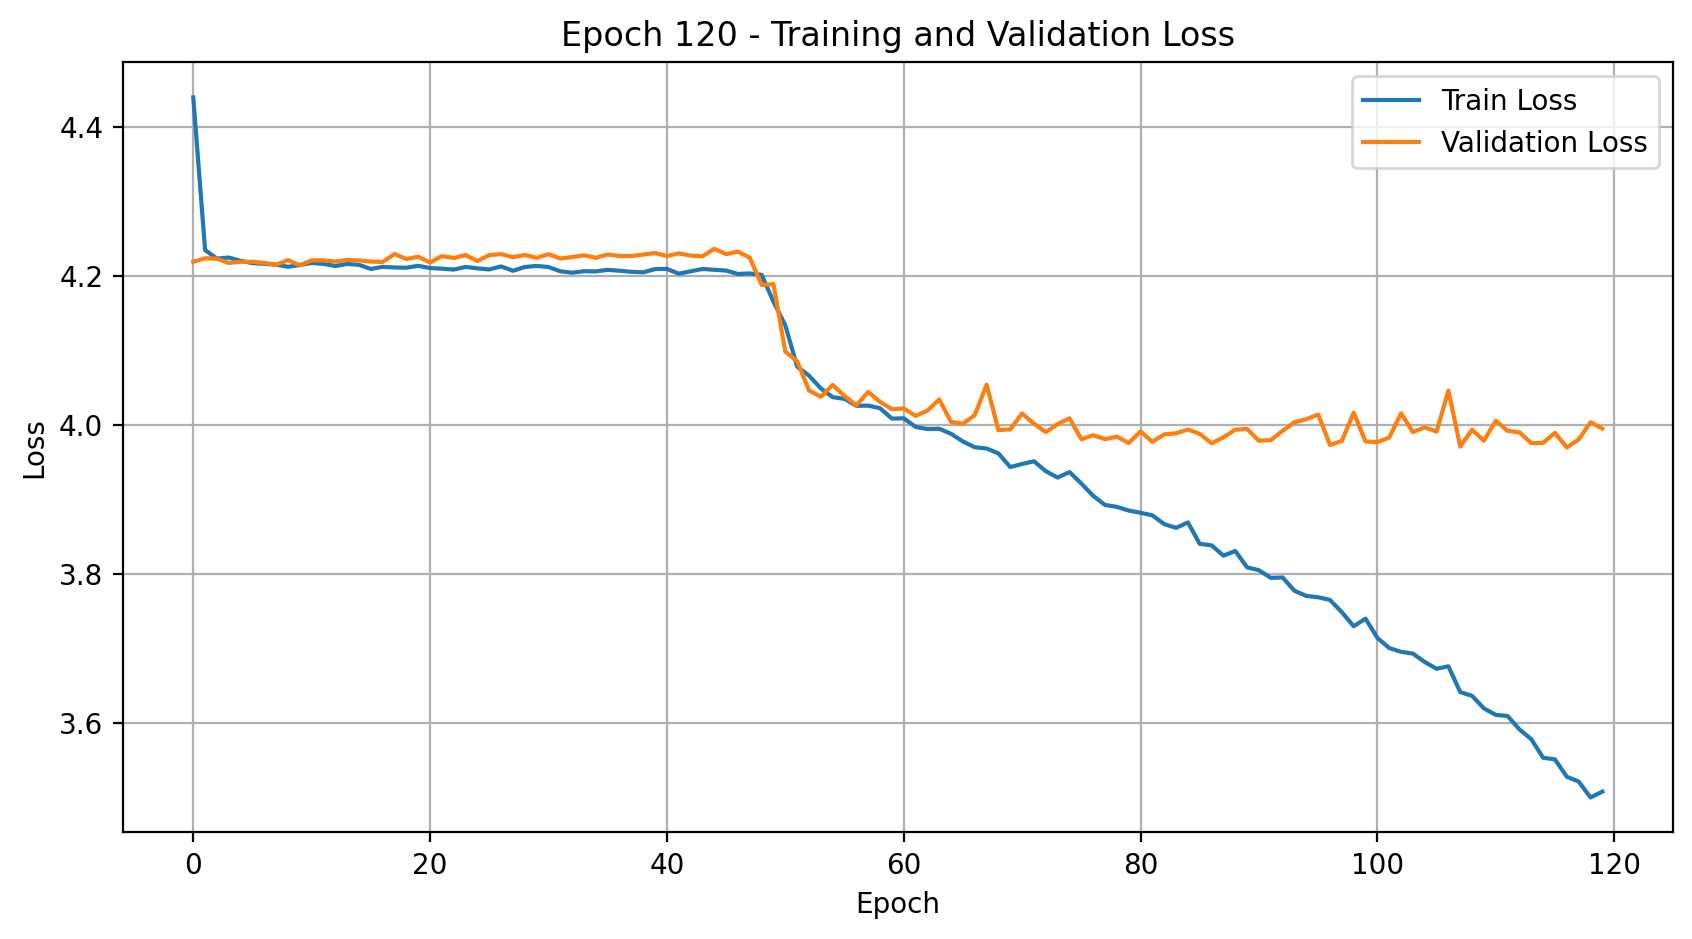

Epoch 121/200
Epoch 122/200
Epoch 123/200
Epoch 124/200
Epoch 125/200
Epoch 126/200
Epoch 127/200
Epoch 128/200
Epoch 129/200
Epoch 130/200


<Figure size 640x480 with 0 Axes>

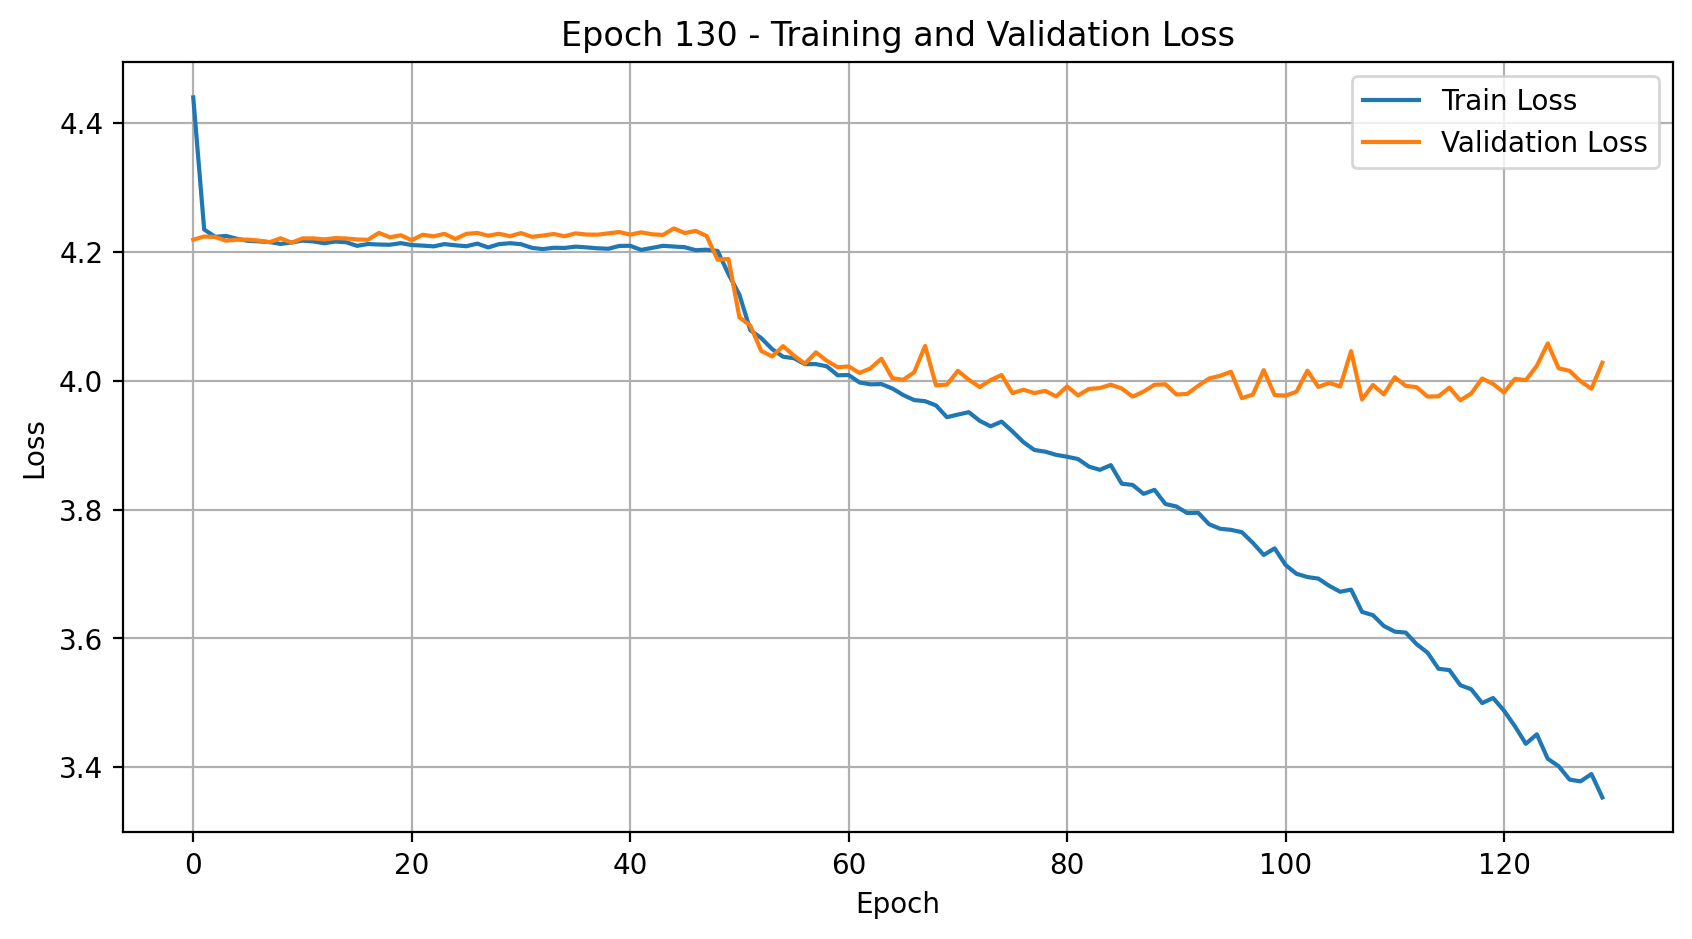

Epoch 131/200
Epoch 132/200
Epoch 133/200
Epoch 134/200
Epoch 135/200
Epoch 136/200
Epoch 137/200
Epoch 138/200
Epoch 139/200
Epoch 140/200


<Figure size 640x480 with 0 Axes>

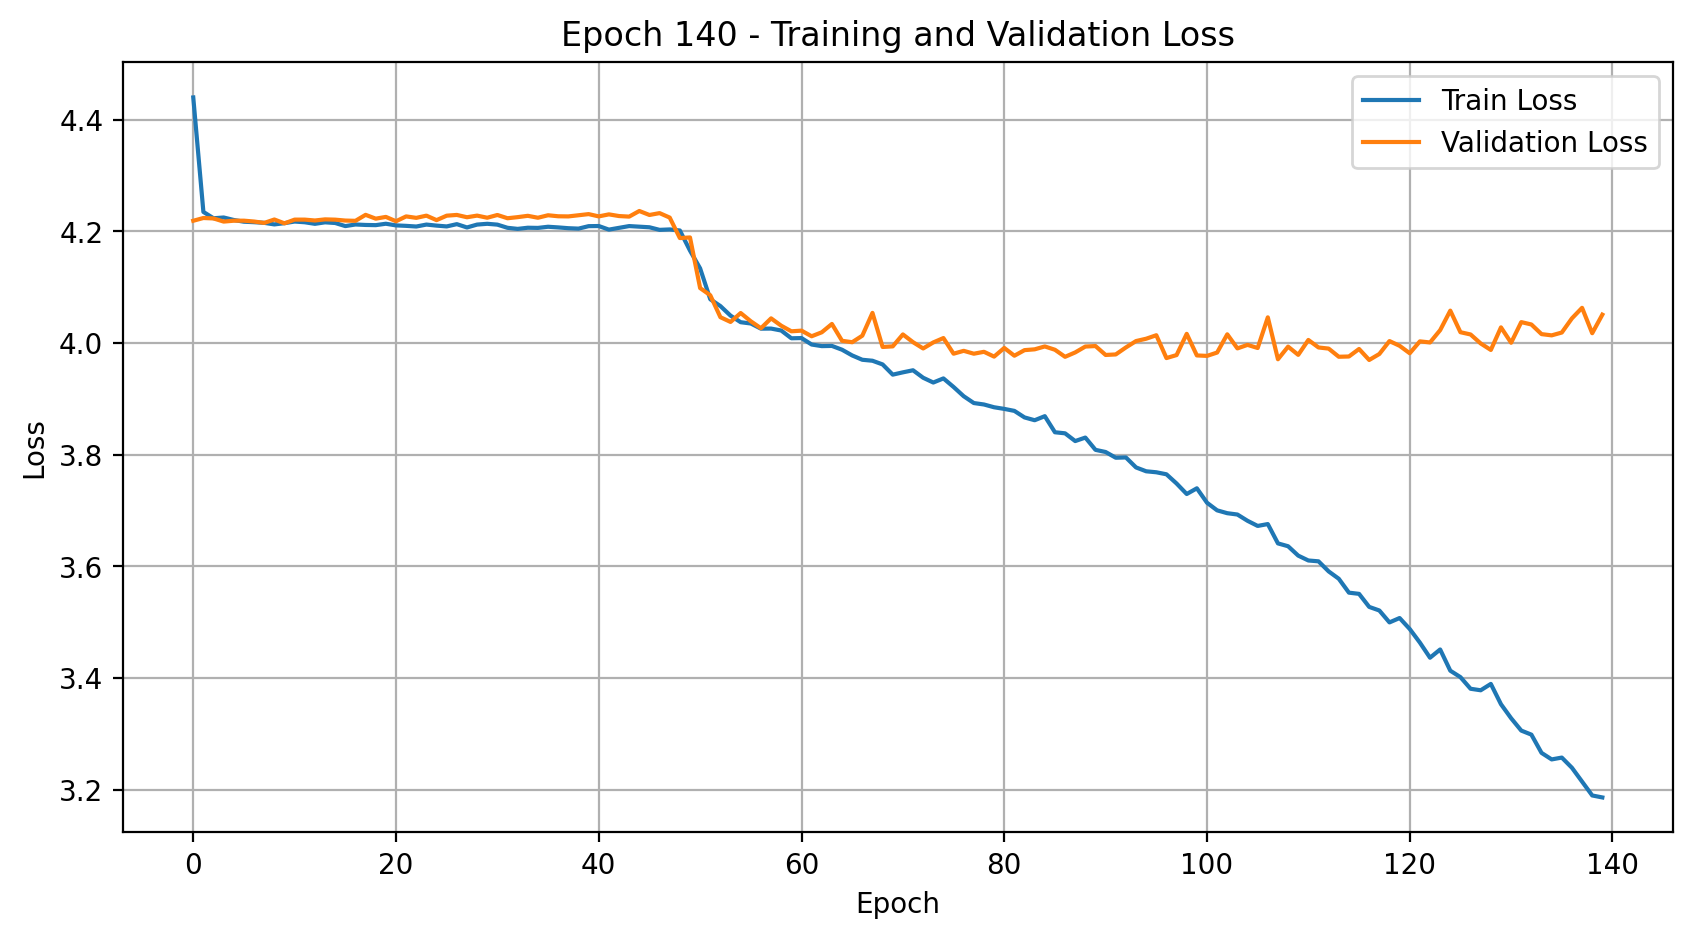

Epoch 141/200
Epoch 142/200
Epoch 143/200
Epoch 144/200
Epoch 145/200
Epoch 146/200
Epoch 147/200
Epoch 148/200
Epoch 149/200
Epoch 150/200


<Figure size 640x480 with 0 Axes>

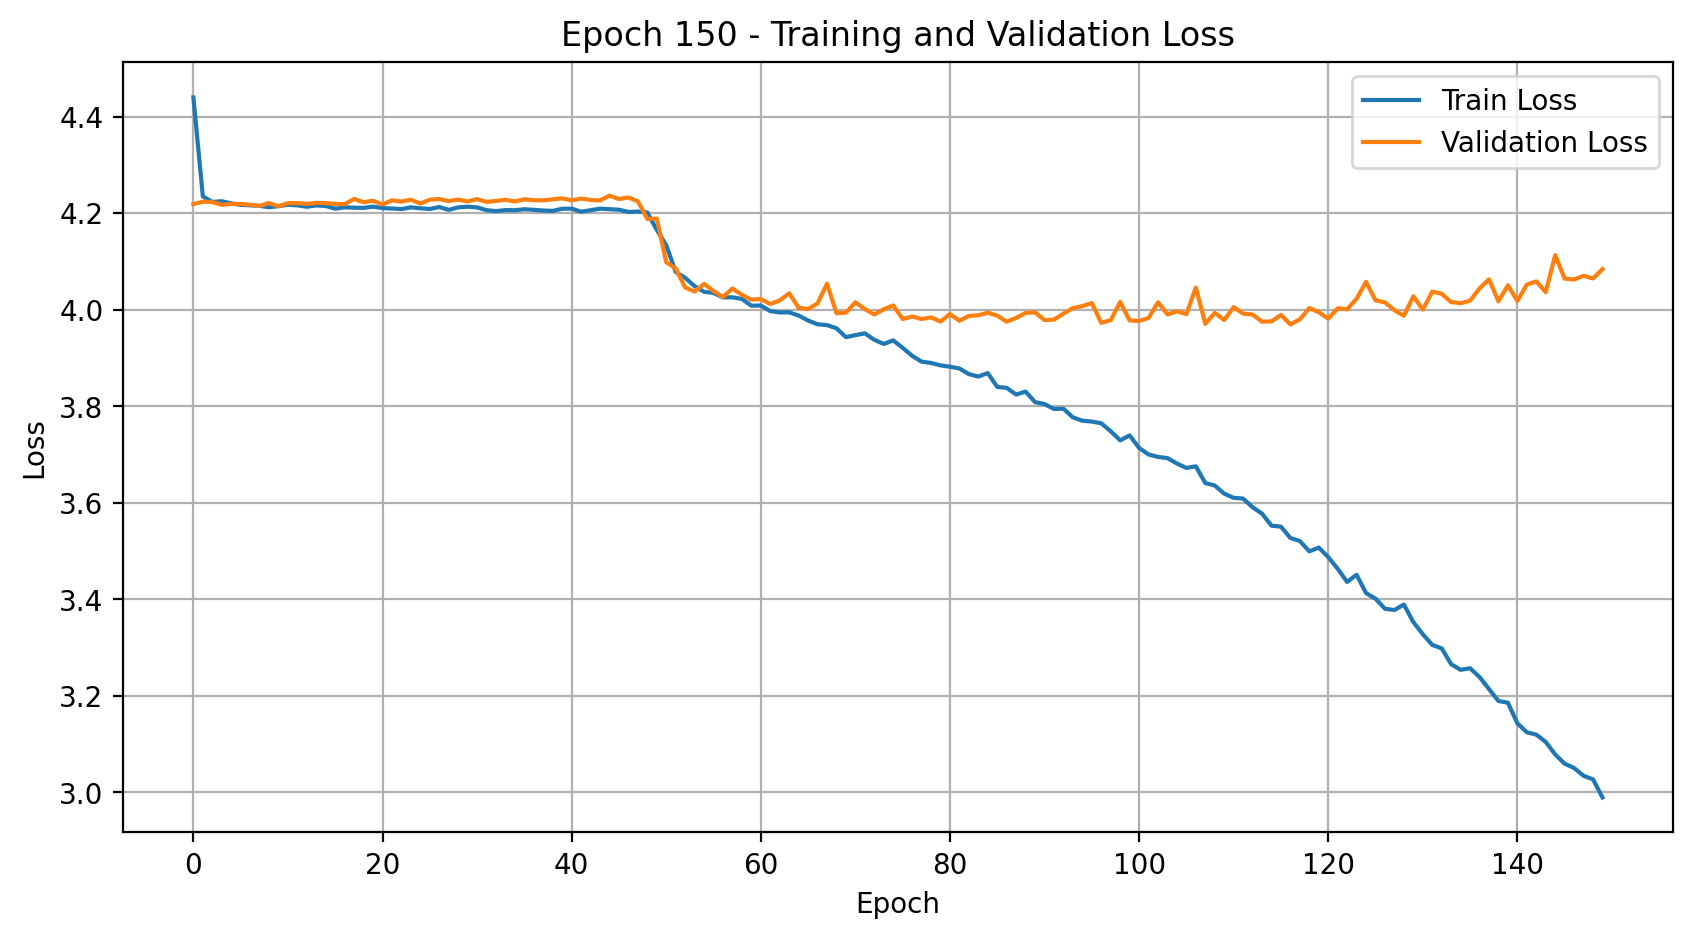

Epoch 151/200
Epoch 152/200
Epoch 153/200
Epoch 154/200
Epoch 155/200
Epoch 156/200
Epoch 157/200
Epoch 158/200
Epoch 159/200
Epoch 160/200


<Figure size 640x480 with 0 Axes>

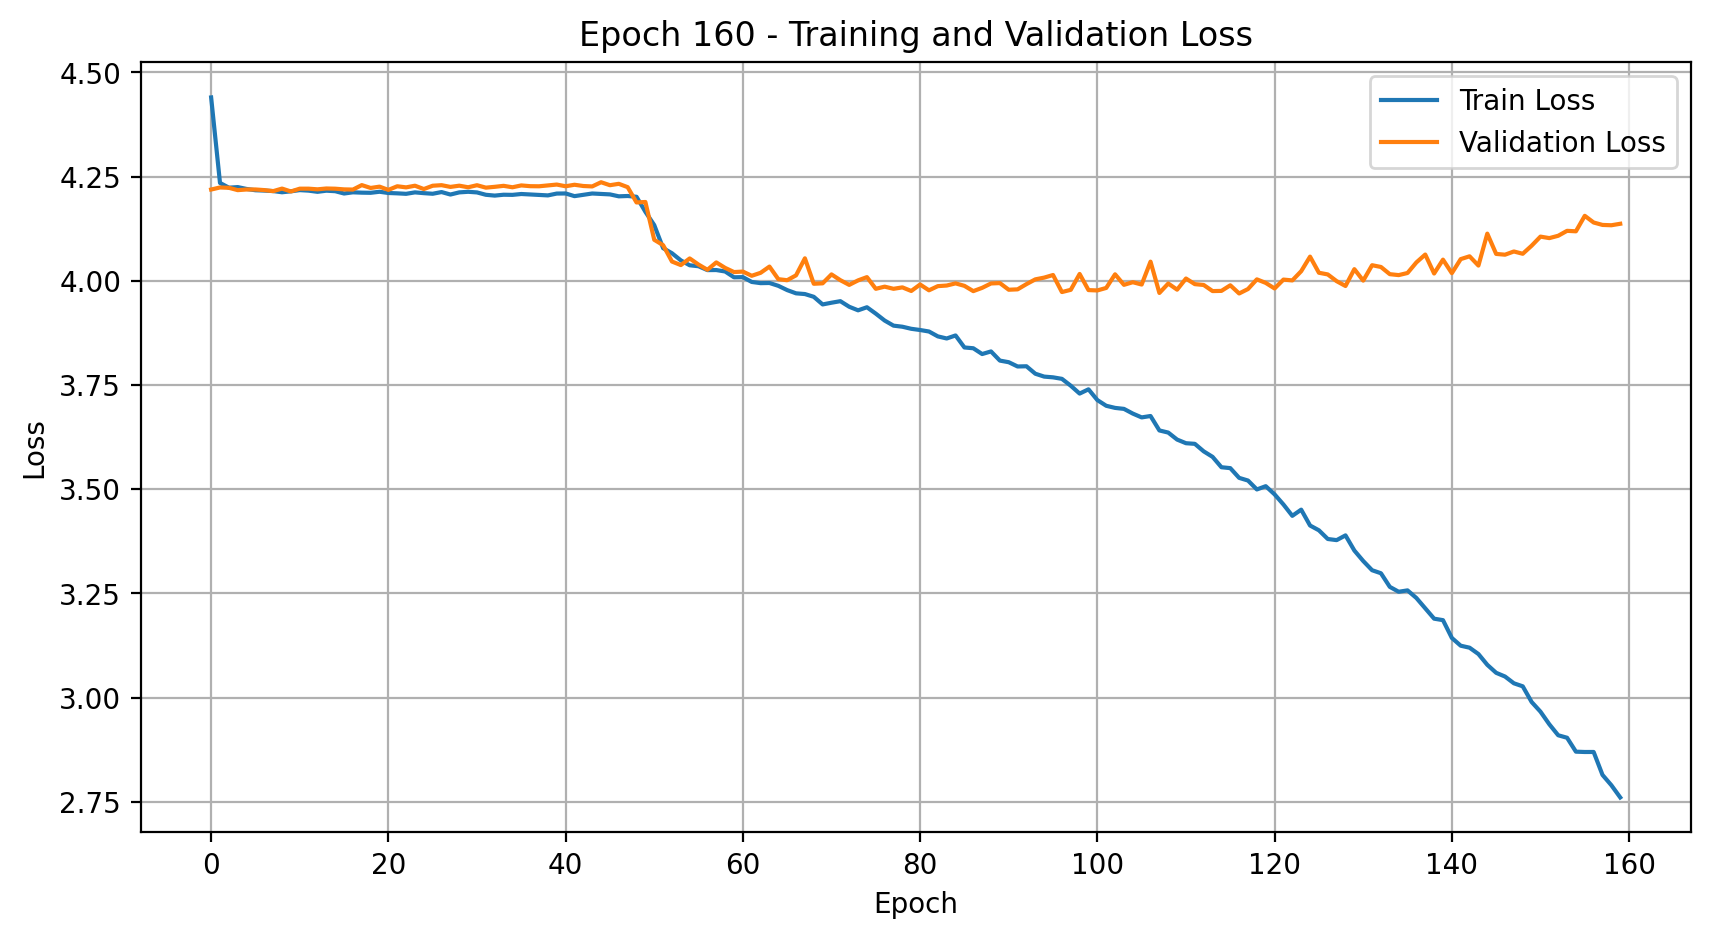

Epoch 161/200
Epoch 162/200
Epoch 163/200
Epoch 164/200
Epoch 165/200
Epoch 166/200


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [115]:
model = LSTMModel(input_size=X_train.shape[2], output_size=y.shape[1])
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

epochs = 200
best_val_loss = float('inf')
patience = 5
trigger_times = 0

train_loss_history = []
val_loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    epoch_train_loss /= len(train_loader)
    train_loss_history.append(epoch_train_loss)
    
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
        val_loss_history.append(val_loss.item())
    
    if epoch % 10 == 0:        
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Validation Loss')
        plt.title(f'Epoch {epoch} - Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()

In [ ]:
def melody_generator(note_count, model, X_test, reverse_mapping, L_symb, temperature=1.0):
    model.eval()
    
    with torch.no_grad():
        music = []
        notes_generated = []
        
        for _ in range(note_count):
            seed = X_test[np.random.randint(0, len(X_test) - 1)]
            seed_tensor = torch.tensor(seed, dtype=torch.float32).unsqueeze(0)
            prediction = model(seed_tensor)
            prediction = prediction.squeeze(0)
            
            prediction = torch.log_softmax(prediction / temperature, dim=-1)
            prediction_probs = torch.exp(prediction)
            index = torch.argmax(prediction_probs).item()
            
            index_N = index / float(L_symb)  
            notes_generated.append(index)
            music.append(reverse_mapping[index])
            
            seed = np.append(seed, [[index_N]], axis=0)
            seed = seed[1:]

        melody = chords_n_notes(music)
        melody_midi = stream.Stream(melody)

    return music, melody_midi

music_notes, melody = melody_generator(50, model, X_test, reverse_mapping, L_symb, temperature=1.0)
melody.write('midi', 'img/output.mid')


'img/output.mid'